In [1]:
# Install missing package in the notebook environment (required to fix ModuleNotFoundError)
import tensorflow as tf
from tensorflow import keras
keras.backend.clear_session()
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
from pyproj import Transformer
from sklearn.preprocessing import StandardScaler
from scipy.linalg import svd
import rasterio
from scipy.interpolate import griddata
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import rasterio
from scipy.interpolate import splprep, splev, Rbf
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from scipy.interpolate import Rbf
from scipy.spatial import cKDTree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 8)
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.decomposition import TruncatedSVD
%pip install torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


Note: you may need to restart the kernel to use updated packages.


In [2]:
# --- Read anomaly data ---
df_anom = pd.read_parquet("../data/df_illgraben_anomaly_scores.parquet", engine='fastparquet')
# --- Read coordinates ---
coords = pd.read_csv(
    "../data/coords.txt",
    sep="|",
    comment="#",
    header=None,
    engine="python"
)

col_names = [
    "Network","Station","Location","Channel","Latitude","Longitude","Elevation",
    "Depth","Azimuth","Dip","SensorDescription","Scale","ScaleFreq",
    "ScaleUnits","SampleRate","StartTime","EndTime"
]
coords.columns = col_names
coords = coords.iloc[1:]  # drop first row if header repetition

# Clean numeric columns
coords["Latitude"] = pd.to_numeric(coords["Latitude"], errors="coerce")
coords["Longitude"] = pd.to_numeric(coords["Longitude"], errors="coerce")
coords["Elevation"] = pd.to_numeric(coords["Elevation"], errors="coerce")

# Keep latest record per station
coords = (
    coords.sort_values(["Station", "StartTime"], ascending=[True, False])
    .drop_duplicates("Station")
    .reset_index(drop=True)
)[["Station", "Latitude", "Longitude", "Elevation"]]


In [3]:
transformer = Transformer.from_crs("epsg:4326", "epsg:2056", always_xy=True)
coords["X_mn95"], coords["Y_mn95"] = transformer.transform(coords["Longitude"].values, coords["Latitude"].values)


In [4]:
# Merge coords
df_merged = df_anom.merge(coords, left_on="station", right_on="Station", how="left")
df_merged = df_merged.dropna(subset=["X_mn95", "Y_mn95"])


In [5]:
print(df_merged.columns)

Index(['station', 'time', 'anomaly_score', 'std', 'debris flow', 'Station',
       'Latitude', 'Longitude', 'Elevation', 'X_mn95', 'Y_mn95'],
      dtype='object')


In [6]:
# Round time to nearest minute
df_merged['time_minute'] = df_merged['time'].dt.round('1min')

# Aggregate by station and minute
df_minute = (df_merged
             .groupby(['station', 'time_minute'])
             .agg({
                 'anomaly_score': 'mean',
                 'debris flow': 'max',  # If any reading in that minute has debris flow
                 'X_mn95': 'first',
                 'Y_mn95': 'first',
                 'Elevation': 'first'
             })
             .reset_index())

print(f"  Original readings: {len(df_merged):,}")
print(f"  After 1-min aggregation: {len(df_minute):,}")
print(f"  Time range: {df_minute['time_minute'].min()} to {df_minute['time_minute'].max()}")


  Original readings: 8,274,482
  After 1-min aggregation: 6,896,017
  Time range: 2018-05-14 11:03:00 to 2022-08-28 21:22:00


In [7]:
# Filter to June 2020
df_june = df_minute[
    (df_minute['time_minute'] >= '2020-06-01') & 
    (df_minute['time_minute'] < '2020-07-01')
].copy()

# Drop ILL14 and ILL15
df_june = df_june[~df_june['station'].isin(['ILL14', 'ILL15'])]

print(f"  June 2020 data points: {len(df_june):,}")
print(f"  Stations: {sorted(df_june['station'].unique())}")

  June 2020 data points: 259,075
  Stations: ['ILL11', 'ILL12', 'ILL13', 'ILL16', 'ILL17', 'ILL18']


In [22]:
# Define debris flow events (max 15-minute gap allowed)
def identify_debris_flow_events(df, max_gap_minutes=15):
    """
    Identify continuous debris flow events with allowed gaps.
    """
    # Sort by time
    df = df.sort_values('time_minute').copy()
    
    # Find where debris flow = 1
    debris_times = df[df['debris flow'] == 1]['time_minute'].unique()
    debris_times = pd.Series(sorted(debris_times))
    
    if len(debris_times) == 0:
        df['event_id'] = 0
        return df, pd.DataFrame()
    
    # Calculate time gaps between consecutive debris flow minutes
    time_diffs = debris_times.diff()
    
    # Start new event when gap > max_gap_minutes OR at the very first debris flow
    event_breaks = (time_diffs > pd.Timedelta(minutes=max_gap_minutes)) | (time_diffs.isna())
    event_ids = event_breaks.cumsum()  # This now starts at 1 for the first event
    
    # Create mapping from time to event_id
    time_to_event = pd.DataFrame({
        'time_minute': debris_times,
        'event_id': event_ids.values
    })
    
    # Merge back to main dataframe
    df = df.merge(time_to_event, on='time_minute', how='left')
    df['event_id'] = df['event_id'].fillna(0).astype(int)
    
    # Create event summary
    events_summary = (df[df['event_id'] > 0]
                     .groupby('event_id')
                     .agg({
                         'time_minute': ['min', 'max', 'count'],
                     }))
    events_summary.columns = ['start_time', 'end_time', 'n_minutes']
    events_summary['duration_min'] = (
        (events_summary['end_time'] - events_summary['start_time']).dt.total_seconds() / 60
    )
    
    return df, events_summary

df_june, events_summary = identify_debris_flow_events(df_june, max_gap_minutes=15)

print(f"\n  Debris flow events identified: {len(events_summary)}")
if len(events_summary) > 0:
    print(f"  Event durations (minutes): {events_summary['duration_min'].describe().to_dict()}")
    print("\n  Event details:")
    for event_id, row in events_summary.iterrows():
        print(f"    Event {event_id}: {row['start_time']} to {row['end_time']} "
              f"({row['duration_min']:.0f} min, {row['n_minutes']} readings)")

# Filter to keep only 30-minute windows before and after each event
if len(events_summary) > 0:
    window_minutes = 30
    
    # Create list of time ranges to keep
    keep_mask = pd.Series(False, index=df_june.index)
    
    for event_id, row in events_summary.iterrows():
        event_start = row['start_time']
        event_end = row['end_time']
        
        # Define window: 30 min before event to 30 min after event
        window_start = event_start - pd.Timedelta(minutes=window_minutes)
        window_end = event_end + pd.Timedelta(minutes=window_minutes)
        
        # Mark rows in this window
        in_window = (df_june['time_minute'] >= window_start) & (df_june['time_minute'] <= window_end)
        keep_mask |= in_window
        
        print(f"\n    Event {event_id} window: {window_start} to {window_end}")
    
    # Filter dataframe
    df_june_windowed = df_june[keep_mask].copy()
    
    print(f"\n  Original data: {len(df_june)} timepoints")
    print(f"  Windowed data: {len(df_june_windowed)} timepoints")
    print(f"  Reduction: {100 * (1 - len(df_june_windowed)/len(df_june)):.1f}%")
    
    # Use the windowed data for subsequent analysis
    df_june = df_june_windowed
else:
    print("\n  No debris flow events found - keeping all data")


  Debris flow events identified: 8
  Event durations (minutes): {'count': 8.0, 'mean': 107.5, 'std': 72.53570549342284, 'min': 15.0, '25%': 47.0, '50%': 115.5, '75%': 154.0, 'max': 220.0}

  Event details:
    Event 1: 2020-06-04 14:51:00 to 2020-06-04 17:21:00 (150 min, 906 readings)
    Event 2: 2020-06-07 07:10:00 to 2020-06-07 09:56:00 (166 min, 1002 readings)
    Event 3: 2020-06-08 13:38:00 to 2020-06-08 14:33:00 (55 min, 336 readings)
    Event 4: 2020-06-08 14:50:00 to 2020-06-08 15:13:00 (23 min, 144 readings)
    Event 5: 2020-06-08 15:44:00 to 2020-06-08 15:59:00 (15 min, 96 readings)
    Event 6: 2020-06-08 16:36:00 to 2020-06-08 18:45:00 (129 min, 780 readings)
    Event 7: 2020-06-17 03:18:00 to 2020-06-17 06:58:00 (220 min, 1326 readings)
    Event 8: 2020-06-29 04:29:00 to 2020-06-29 06:11:00 (102 min, 618 readings)

    Event 1 window: 2020-06-04 14:21:00 to 2020-06-04 17:51:00

    Event 2 window: 2020-06-07 06:40:00 to 2020-06-07 10:26:00

    Event 3 window: 2020-0

### Data Prep

In [44]:
# Define stations
train_stations = ['ILL11', 'ILL13', 'ILL16', 'ILL12', 'ILL17']
test_station = 'ILL18'
all_stations = train_stations + [test_station]

print(f"  All stations: {all_stations}")
print(f"  Test station: {test_station}")

# Create wide format with all stations
df_wide_all = df_june.pivot(
    index='time_minute',
    columns='station',
    values='anomaly_score'
)[all_stations]  # Ensure column order

# Fill missing values
df_wide_all_filled = df_wide_all.fillna(method='ffill').fillna(method='bfill')

print(f"  Data shape: {df_wide_all_filled.shape}")
print(f"  Columns: {list(df_wide_all_filled.columns)}")
print(f"  Time range: {df_wide_all_filled.index.min()} to {df_wide_all_filled.index.max()}")

# Get test station index for later
test_station_idx = all_stations.index(test_station)
print(f"  Test station index in data: {test_station_idx}")

  All stations: ['ILL11', 'ILL13', 'ILL16', 'ILL12', 'ILL17', 'ILL18']
  Test station: ILL18
  Data shape: (43200, 6)
  Columns: ['ILL11', 'ILL13', 'ILL16', 'ILL12', 'ILL17', 'ILL18']
  Time range: 2020-06-01 00:00:00 to 2020-06-30 23:59:00
  Test station index in data: 5


In [46]:
# Standardize training data

# Fit scaler on ALL stations
scaler = StandardScaler()
all_data_scaled = scaler.fit_transform(df_wide_all_filled)

print(f"  Scaled data shape: {all_data_scaled.shape}")
print(f"  Mean per station: {scaler.mean_}")
print(f"  Std per station: {scaler.scale_}")

# Extract test station statistics for later un-standardization
test_station_mean = scaler.mean_[test_station_idx]
test_station_std = scaler.scale_[test_station_idx]

print(f"  Test station ({test_station}) mean: {test_station_mean:.4f}")
print(f"  Test station ({test_station}) std: {test_station_std:.4f}")


  Scaled data shape: (43200, 6)
  Mean per station: [0.39941828 0.41791072 0.38233272 0.37959733 0.42475361 0.3879954 ]
  Std per station: [0.06384578 0.06553443 0.04296702 0.06030693 0.07590902 0.0660443 ]
  Test station (ILL18) mean: 0.3880
  Test station (ILL18) std: 0.0660


### SVD

  U (temporal modes) shape: (43200, 4)
  S (singular values): [375.97746841 217.59032435 171.16549456 146.14177518]
  V (spatial loadings) shape: (6, 4)
  Explained variance ratio: [0.54536673 0.1826603  0.11303097 0.08239745]
  Total variance explained: 92.35%

  Test station (ILL18) loadings (V): [ 0.41579594  0.25628307 -0.35361851  0.69840776]
  Saved: svd_reconstruction_temporal_modes.png


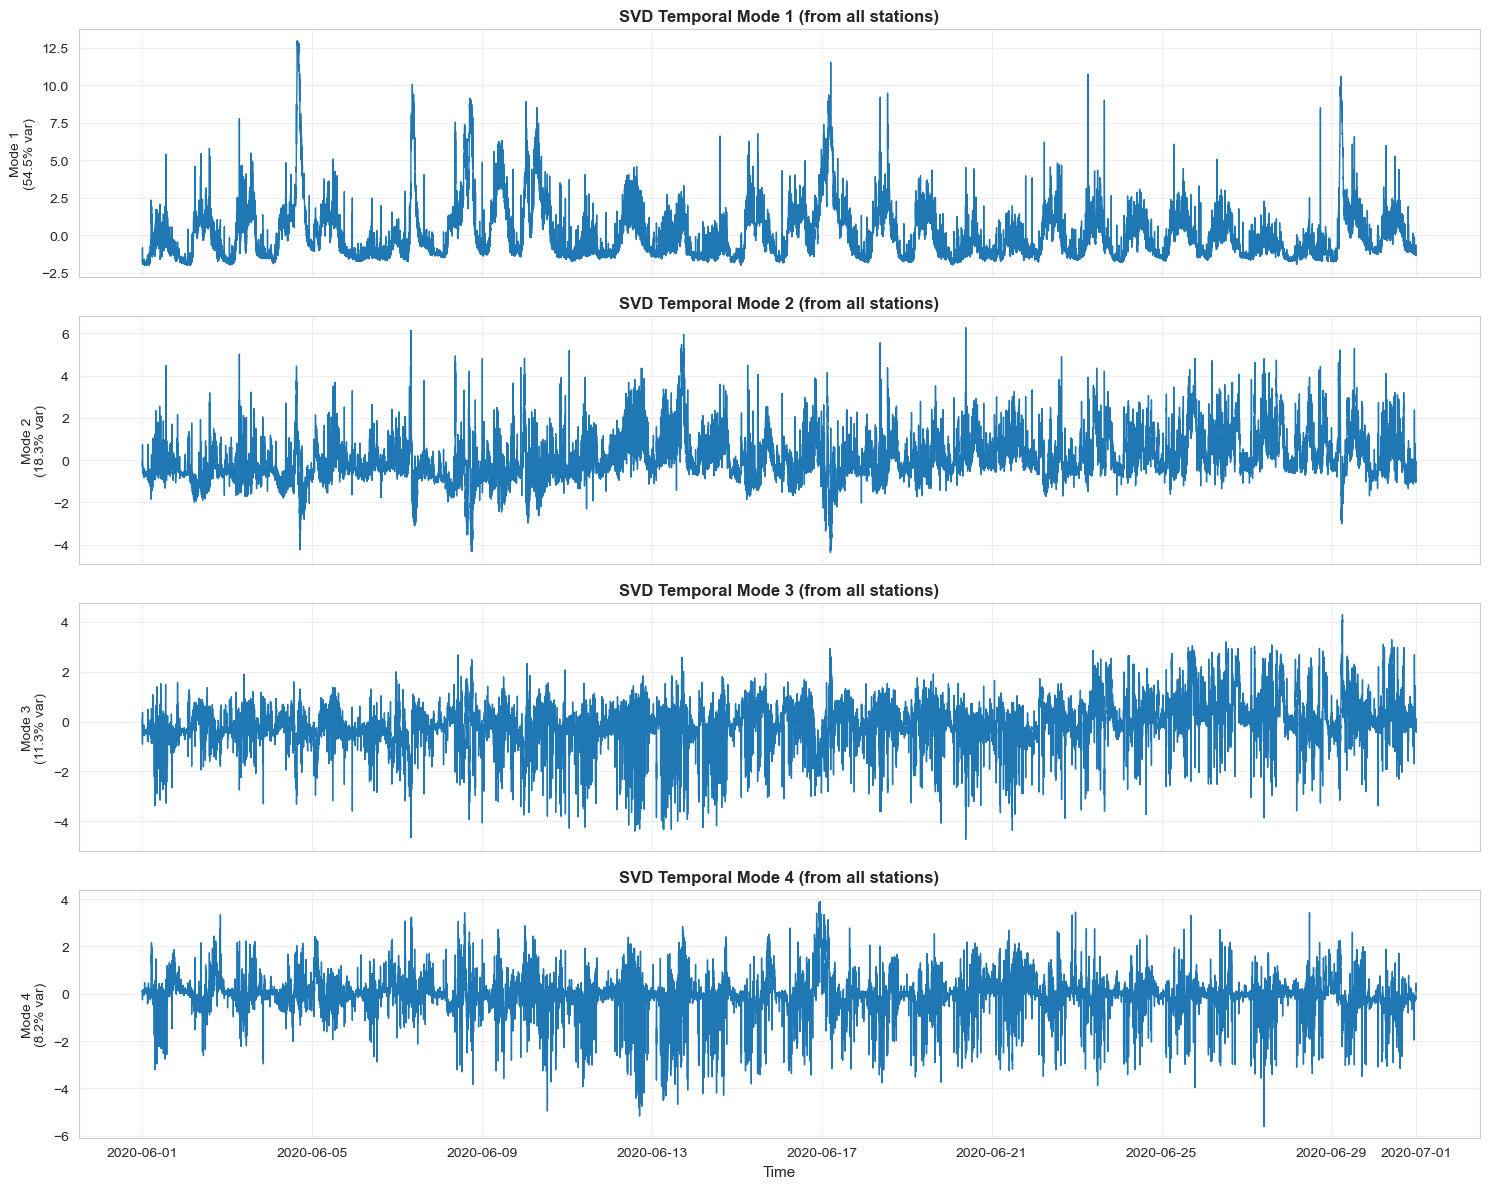

In [47]:
n_components = 4  # Number of temporal modes

# Perform SVD
svd = TruncatedSVD(n_components=n_components, random_state=42)
U = svd.fit_transform(all_data_scaled)
S = svd.singular_values_
V = svd.components_.T  # Shape: (6 stations, 3 components)

print(f"  U (temporal modes) shape: {U.shape}")
print(f"  S (singular values): {S}")
print(f"  V (spatial loadings) shape: {V.shape}")
print(f"  Explained variance ratio: {svd.explained_variance_ratio_}")
print(f"  Total variance explained: {svd.explained_variance_ratio_.sum():.2%}")

# Extract test station loadings
V_test_station = V[test_station_idx, :]  # Shape: (3,)
print(f"\n  Test station ({test_station}) loadings (V): {V_test_station}")

# FREEZE SVD components
FROZEN_U = U.copy()
FROZEN_S = S.copy()
FROZEN_V = V.copy()
FROZEN_V_TEST = V_test_station.copy()


# Visualize temporal modes
fig, axes = plt.subplots(n_components, 1, figsize=(15, 3*n_components), sharex=True)
for i in range(n_components):
    axes[i].plot(df_wide_all_filled.index, U[:, i], linewidth=1)
    axes[i].set_ylabel(f'Mode {i+1}\n({svd.explained_variance_ratio_[i]:.1%} var)', fontsize=10)
    axes[i].grid(alpha=0.3)
    axes[i].set_title(f'SVD Temporal Mode {i+1} (from all stations)', fontsize=12, fontweight='bold')

axes[-1].set_xlabel('Time', fontsize=11)
plt.tight_layout()
plt.savefig('svd_reconstruction_temporal_modes.png', dpi=300, bbox_inches='tight')
print("  Saved: svd_reconstruction_temporal_modes.png")
plt.show()

### LSTM

In [48]:
# Split time into train/validation (80/20)
temporal_split_idx = int(len(df_wide_all_filled) * 0.8)

print(f"  Total timepoints: {len(df_wide_all_filled)}")
print(f"  Training timepoints: 0 to {temporal_split_idx}")
print(f"  Validation timepoints: {temporal_split_idx} to {len(df_wide_all_filled)}")

# Split U (temporal modes)
U_train = U[:temporal_split_idx, :]
U_val = U[temporal_split_idx:, :]

# Get actual test station values
test_actual = df_wide_all_filled[test_station].values
test_actual_train = test_actual[:temporal_split_idx]
test_actual_val = test_actual[temporal_split_idx:]

print(f"  U_train shape: {U_train.shape}")
print(f"  U_val shape: {U_val.shape}")

  Total timepoints: 43200
  Training timepoints: 0 to 34560
  Validation timepoints: 34560 to 43200
  U_train shape: (34560, 4)
  U_val shape: (8640, 4)


In [49]:
class ReconstructionLSTM(nn.Module):
    def __init__(self, n_components, lookback, hidden_size=32):
        super().__init__()
        
        # LSTM predicts NEXT U value (staying in U-space)
        self.lstm = nn.LSTM(
            input_size=n_components,
            hidden_size=hidden_size,
            num_layers=2,
            batch_first=True,
            dropout=0.2
        )
        
        # Output: next U values (3 components)
        self.fc = nn.Linear(hidden_size, n_components)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_output = lstm_out[:, -1, :]
        next_u = self.fc(last_output)
        return next_u

print(f"  Architecture: Input({n_components} U values) → LSTM(32 hidden) → Output({n_components} next U values)")

  Architecture: Input(4 U values) → LSTM(32 hidden) → Output(4 next U values)


In [50]:
class ReconstructionDataset(Dataset):
    def __init__(self, U, lookback=20):
        self.U = U
        self.lookback = lookback
    
    def __len__(self):
        return len(self.U) - self.lookback
    
    def __getitem__(self, idx):
        # Input: past U values
        u_window = self.U[idx:idx+self.lookback]
        
        # Target: NEXT U value (not anomaly score!)
        next_u = self.U[idx + self.lookback]
        
        return torch.FloatTensor(u_window), torch.FloatTensor(next_u)

# Create datasets
lookback = 20

train_dataset = ReconstructionDataset(U_train, lookback)
val_dataset = ReconstructionDataset(U_val, lookback)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"  Lookback window: {lookback} minutes")
print(f"  Train dataset size: {len(train_dataset)}")
print(f"  Validation dataset size: {len(val_dataset)}")
print(f"  Target: NEXT U value (shape: {n_components}), NOT anomaly score")

  Lookback window: 20 minutes
  Train dataset size: 34540
  Validation dataset size: 8620
  Target: NEXT U value (shape: 4), NOT anomaly score


  Epoch 10/50 | Train Loss: 0.132310 | Val Loss: 0.128921
  Epoch 20/50 | Train Loss: 0.126295 | Val Loss: 0.121734
  Epoch 30/50 | Train Loss: 0.121798 | Val Loss: 0.123188
  Epoch 40/50 | Train Loss: 0.117496 | Val Loss: 0.130936
  Epoch 50/50 | Train Loss: 0.114646 | Val Loss: 0.132344
----------------------------------------------------------------------
  ✓ Training complete
  ✓ Best validation loss (U prediction): 0.120694
  Saved: lstm_reconstruction_training_curves.png


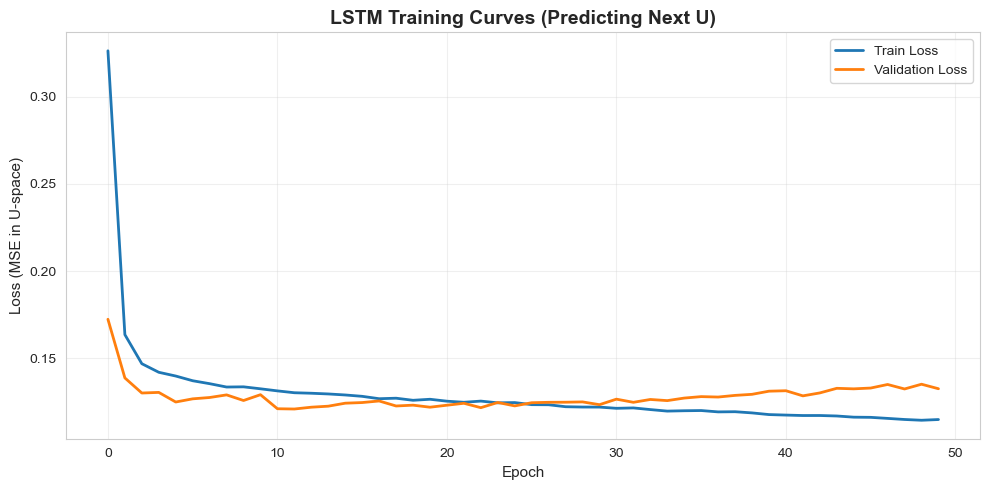

In [51]:
# Initialize model
model = ReconstructionLSTM(n_components=n_components, lookback=lookback, hidden_size=32)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
n_epochs = 50
best_val_loss = float('inf')
best_model_state = None

train_losses = []
val_losses = []

for epoch in range(n_epochs):
    # Train
    model.train()
    train_loss = 0
    for u_window, next_u_target in train_loader:
        optimizer.zero_grad()
        predicted_next_u = model(u_window)
        loss = criterion(predicted_next_u, next_u_target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # Validate
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for u_window, next_u_target in val_loader:
            predicted_next_u = model(u_window)
            loss = criterion(predicted_next_u, next_u_target)
            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict().copy()
    
    if (epoch + 1) % 10 == 0:
        print(f'  Epoch {epoch+1}/{n_epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}')

# Load best model
model.load_state_dict(best_model_state)

print("-"*70)
print(f"  ✓ Training complete")
print(f"  ✓ Best validation loss (U prediction): {best_val_loss:.6f}")

# Plot training curves
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(train_losses, label='Train Loss', linewidth=2)
ax.plot(val_losses, label='Validation Loss', linewidth=2)
ax.set_xlabel('Epoch', fontsize=11)
ax.set_ylabel('Loss (MSE in U-space)', fontsize=11)
ax.set_title('LSTM Training Curves (Predicting Next U)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('lstm_reconstruction_training_curves.png', dpi=300, bbox_inches='tight')
print("  Saved: lstm_reconstruction_training_curves.png")
plt.show()

### Prediction

In [52]:
# Predict U for all timepoints
predicted_U = np.zeros_like(U)

model.eval()
with torch.no_grad():
    for i in range(lookback, len(U)):
        u_window = U[i-lookback:i]
        u_tensor = torch.FloatTensor(u_window).unsqueeze(0)
        predicted_next_u = model(u_tensor).numpy().flatten()
        predicted_U[i] = predicted_next_u

print(f"  Predicted U shape: {predicted_U.shape}")

# Reconstruct ALL stations in scaled space
# Data_scaled = U @ S @ V^T
# But TruncatedSVD uses: Data_scaled ≈ U @ V^T (S is absorbed in V during fit)
reconstructed_all_scaled = svd.inverse_transform(predicted_U)  # Shape: (n_timepoints, 6 stations)

print(f"  Reconstructed all stations (scaled) shape: {reconstructed_all_scaled.shape}")

# Extract test station column
reconstructed_test_scaled = reconstructed_all_scaled[:, test_station_idx]

print(f"  Extracted test station (scaled) shape: {reconstructed_test_scaled.shape}")

# Un-standardize using test station's mean and std
reconstructed_test = reconstructed_test_scaled * test_station_std + test_station_mean

print(f"  Reconstructed test station (un-scaled) shape: {reconstructed_test.shape}")
print(f"  Reconstruction method: inverse_transform(U_predicted) then extract column")

# Verify the reconstruction makes sense
print(f"    Actual test station range: [{test_actual.min():.4f}, {test_actual.max():.4f}]")
print(f"    Reconstructed range: [{reconstructed_test.min():.4f}, {reconstructed_test.max():.4f}]")
print(f"    Actual mean: {test_actual.mean():.4f}")
print(f"    Reconstructed mean: {reconstructed_test.mean():.4f}")

  Predicted U shape: (43200, 4)
  Reconstructed all stations (scaled) shape: (43200, 6)
  Extracted test station (scaled) shape: (43200,)
  Reconstructed test station (un-scaled) shape: (43200,)
  Reconstruction method: inverse_transform(U_predicted) then extract column
    Actual test station range: [0.3306, 0.7752]
    Reconstructed range: [0.3292, 0.8407]
    Actual mean: 0.3880
    Reconstructed mean: 0.3877


In [53]:
# Metrics on validation set
actual_val = test_actual_val[lookback:]
predicted_val = reconstructed_test[temporal_split_idx+lookback:]

rmse_val = np.sqrt(mean_squared_error(actual_val, predicted_val))
mae_val = mean_absolute_error(actual_val, predicted_val)
r2_val = r2_score(actual_val, predicted_val)

print("Test Set Results (Reconstruction):")

print(f"  RMSE: {rmse_val:.4f}")
print(f"  MAE:  {mae_val:.4f}")
print(f"  R²:   {r2_val:.4f}")

# Metrics on debris flow times only
debris_flow_indicator = df_june.groupby('time_minute')['debris flow'].max()
debris_flow_indicator = debris_flow_indicator.reindex(df_wide_all_filled.index).fillna(0)

debris_mask_val = debris_flow_indicator.values[temporal_split_idx+lookback:] == 1

if debris_mask_val.sum() > 0:
    rmse_debris = np.sqrt(mean_squared_error(actual_val[debris_mask_val], predicted_val[debris_mask_val]))
    mae_debris = mean_absolute_error(actual_val[debris_mask_val], predicted_val[debris_mask_val])
    r2_debris = r2_score(actual_val[debris_mask_val], predicted_val[debris_mask_val])
    
    print("\n Debris Flow Times  (Test Set):")
    print(f"  RMSE: {rmse_debris:.4f}")
    print(f"  MAE:  {mae_debris:.4f}")
    print(f"  R²:   {r2_debris:.4f}")
    print(f"  Number of debris flow timepoints: {debris_mask_val.sum()}")
else:
    print("\nNo debris flow events in validation set")


Test Set Results (Reconstruction):
  RMSE: 0.0228
  MAE:  0.0135
  R²:   0.8156

 Debris Flow Times  (Test Set):
  RMSE: 0.0616
  MAE:  0.0533
  R²:   0.7221
  Number of debris flow timepoints: 103


  Saved: svd_lstm_reconstruction_full.png


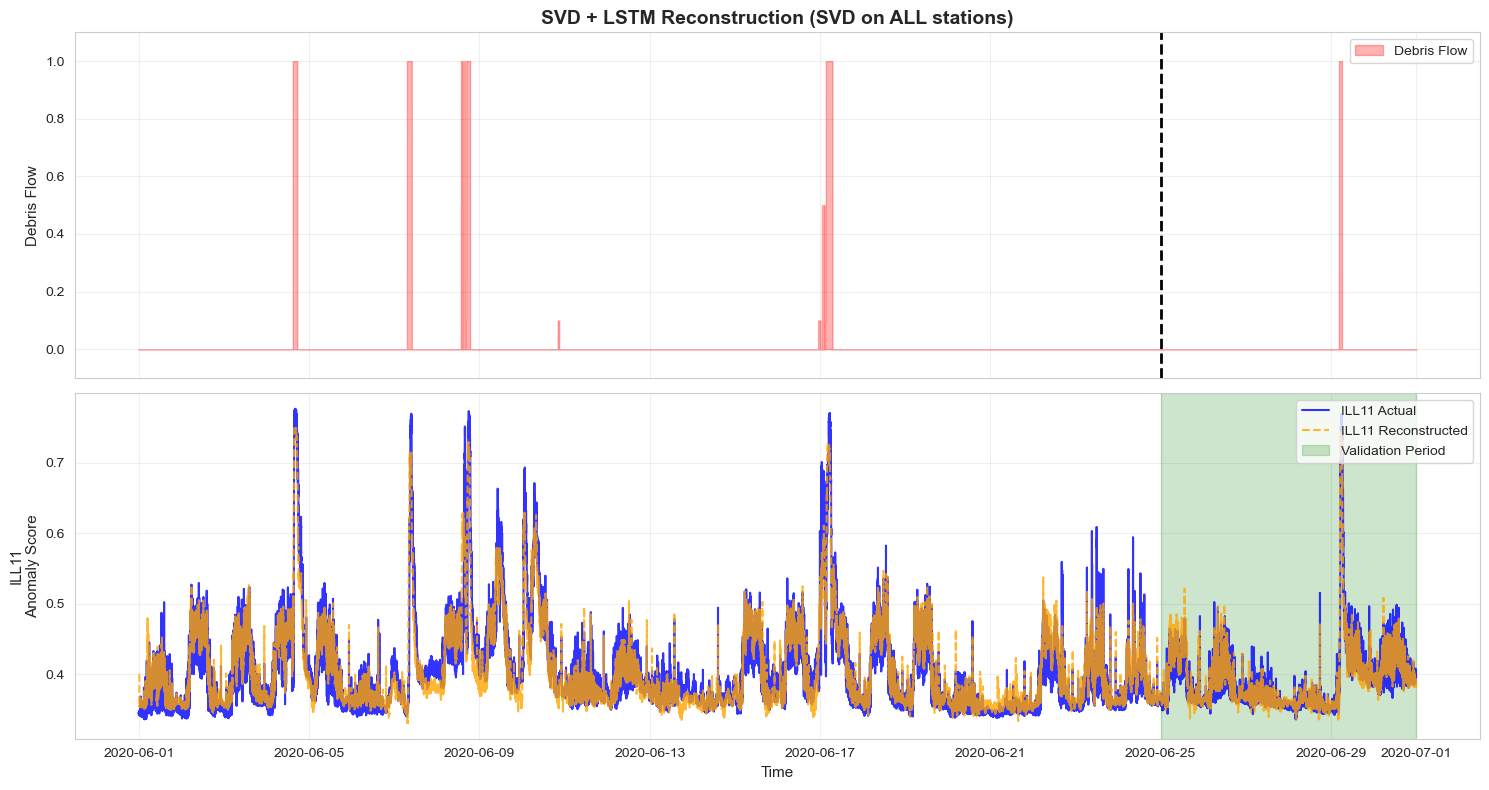

  Saved: svd_lstm_reconstruction_scatter_validation.png


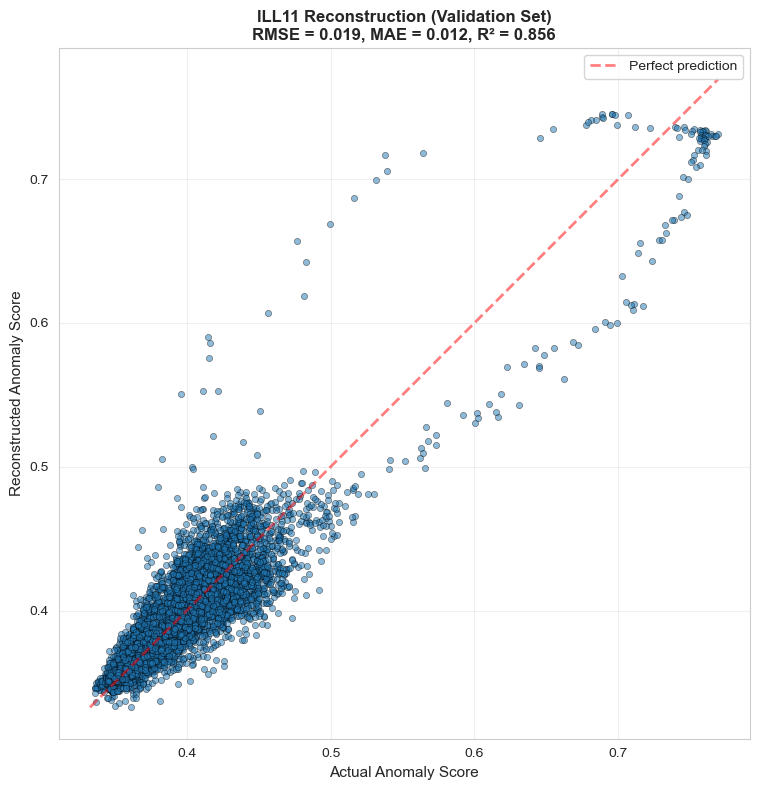

  Saved: svd_lstm_reconstruction_scatter_debris_flow.png


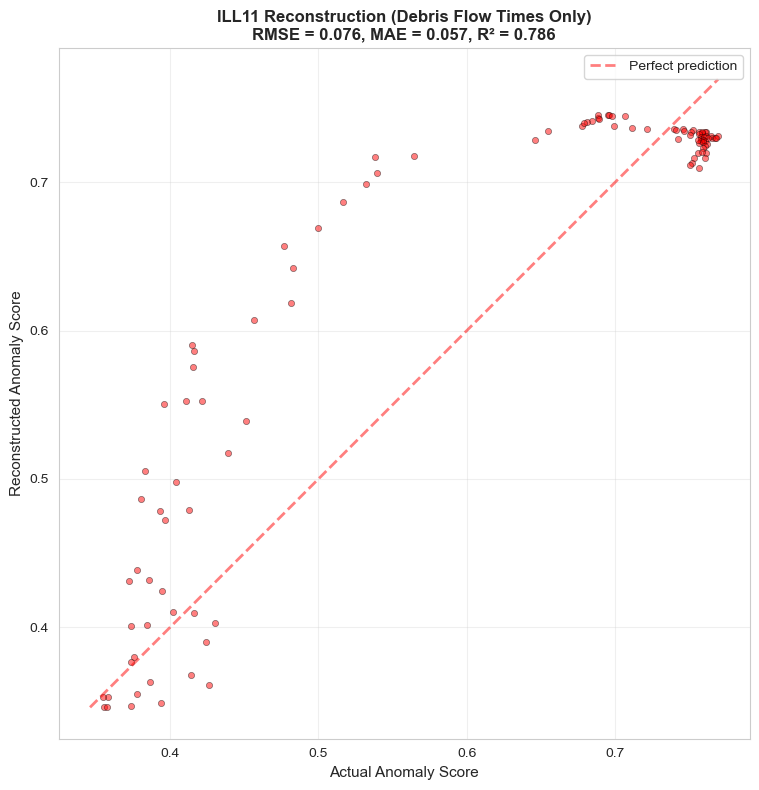


Summary:
  SVD fitted on ALL 6 stations (including test)
  Final R² on validation set: 0.8557


In [25]:
# Full time series plot
fig, axes = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

# Debris flow indicator
axes[0].fill_between(df_wide_all_filled.index, 0, 
                     debris_flow_indicator.values, 
                     alpha=0.3, color='red', label='Debris Flow')
axes[0].set_ylabel('Debris Flow', fontsize=11)
axes[0].set_ylim([-0.1, 1.1])
axes[0].legend(loc='upper right')
axes[0].set_title('SVD + LSTM Reconstruction (SVD on ALL stations)', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# Add vertical line at train/val split
axes[0].axvline(df_wide_all_filled.index[temporal_split_idx], 
                color='black', linestyle='--', linewidth=2, label='Train/Val Split')

# Predictions vs actual
axes[1].plot(df_wide_all_filled.index, test_actual,
            label=f'{test_station} Actual', linewidth=1.5, alpha=0.8, color='blue')
axes[1].plot(df_wide_all_filled.index, reconstructed_test,
            label=f'{test_station} Reconstructed', linewidth=1.5, alpha=0.8, 
            color='orange', linestyle='--')

# Shade validation period
axes[1].axvspan(df_wide_all_filled.index[temporal_split_idx], 
                df_wide_all_filled.index[-1],
                alpha=0.2, color='green', label='Validation Period')

axes[1].set_ylabel(f'{test_station}\nAnomaly Score', fontsize=11)
axes[1].set_xlabel('Time', fontsize=11)
axes[1].legend(loc='upper right')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('svd_lstm_reconstruction_full.png', dpi=300, bbox_inches='tight')
print("  Saved: svd_lstm_reconstruction_full.png")
plt.show()

# Scatter plot - validation set only
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.scatter(actual_val, predicted_val, alpha=0.5, s=20, edgecolors='black', linewidth=0.5)

# Add diagonal line
lims = [min(actual_val.min(), predicted_val.min()),
        max(actual_val.max(), predicted_val.max())]
ax.plot(lims, lims, 'r--', alpha=0.5, linewidth=2, label='Perfect prediction')

ax.set_xlabel('Actual Anomaly Score', fontsize=11)
ax.set_ylabel('Reconstructed Anomaly Score', fontsize=11)
ax.set_title(f'{test_station} Reconstruction (Validation Set)\n'
             f'RMSE = {rmse_val:.3f}, MAE = {mae_val:.3f}, R² = {r2_val:.3f}',
             fontsize=12, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
ax.set_aspect('equal')

plt.tight_layout()
plt.savefig('svd_lstm_reconstruction_scatter_validation.png', dpi=300, bbox_inches='tight')
print("  Saved: svd_lstm_reconstruction_scatter_validation.png")
plt.show()

# Debris flow times scatter (if available)
if debris_mask_val.sum() > 0:
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    
    ax.scatter(actual_val[debris_mask_val], predicted_val[debris_mask_val], 
               alpha=0.5, s=20, edgecolors='black', linewidth=0.5, color='red')
    
    lims = [min(actual_val[debris_mask_val].min(), predicted_val[debris_mask_val].min()),
            max(actual_val[debris_mask_val].max(), predicted_val[debris_mask_val].max())]
    ax.plot(lims, lims, 'r--', alpha=0.5, linewidth=2, label='Perfect prediction')
    
    ax.set_xlabel('Actual Anomaly Score', fontsize=11)
    ax.set_ylabel('Reconstructed Anomaly Score', fontsize=11)
    ax.set_title(f'{test_station} Reconstruction (Debris Flow Times Only)\n'
                 f'RMSE = {rmse_debris:.3f}, MAE = {mae_debris:.3f}, R² = {r2_debris:.3f}',
                 fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)
    ax.set_aspect('equal')
    
    plt.tight_layout()
    plt.savefig('svd_lstm_reconstruction_scatter_debris_flow.png', dpi=300, bbox_inches='tight')
    print("  Saved: svd_lstm_reconstruction_scatter_debris_flow.png")
    plt.show()


print("\nSummary:")
print(f"  SVD fitted on ALL {len(all_stations)} stations (including test)")
print(f"  Final R² on validation set: {r2_val:.4f}")
